In [73]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from enum import Enum


class ArrayPartitionTypes(Enum):
    complete = "complete"
    block = "block"
    cyclic = "cyclic"

@dataclass(frozen=True)
class ArrayPartition:
    variable: str
    dim: int
    type: ArrayPartitionTypes
    factor: int | None = None

@dataclass(frozen=True)
class MemoryOptimization:
    arrayPartition: ArrayPartition

class PipelineStyle(Enum):
    stp = "stp"
    flp = "flp"
    frp = "frp"

@dataclass(frozen=True)
class Pipeline:
    off: bool
    II: int | None = None
    rewind: bool | None = None
    style: PipelineStyle | None = None

@dataclass(frozen=True)
class Unroll:
    off: bool
    factor: int | None = None
    skip_exit_check: bool | None = None

@dataclass(frozen=True)
class Dataflow:
    pass


@dataclass(frozen=True)
class StructureOptimization:
    label: str
    pipeline: Pipeline | None = None
    unroll: Unroll | None = None
    dataflow: Dataflow | None = None


@dataclass(frozen=True)
class OptimizationStrategy:
    memory: list[MemoryOptimization]
    structure: list[StructureOptimization]

@dataclass(frozen=True)
class HLSReport:
    reportName: str
    latency_ns: int
    bram: int
    dsp: int
    ff: int
    lut: int
    uram: int
    taskSpecificInfo: dict[str, any]
    optimizations: OptimizationStrategy

def toDictRepresentation(report: HLSReport):
    result = {
        "ReportName": [report.reportName],
        "M": [report.taskSpecificInfo["M"]],
        "P": [report.taskSpecificInfo["P"]],
        "N": [report.taskSpecificInfo["N"]],
        "Latency_ns": [report.latency_ns],
        "BRAM": [report.bram],
        "DSP": [report.dsp],
        "FF": [report.ff],
        "LUT": [report.lut],
        "URAM": [report.uram],
    }

    variables: list[str] = []
    dim: list[int] = []
    type: list[ArrayPartitionTypes] = []
    factor: list[int | None] = []
    for m in report.optimizations.memory:
        variables.append(m.arrayPartition.variable)
        dim.append(m.arrayPartition.dim)
        type.append(m.arrayPartition.type.name)
        factor.append(m.arrayPartition.factor)

    memory = {
        "ReportName": [report.reportName for i in range(len(variables))],
        "Variables": variables,
        "Dim": dim,
        "Type": type,
        "Factor": factor
    }


    labels: list[str] = []
    optimizationTechniques: list[str] = []
    
    pipelineOff: list[bool | None] = []
    pipelineII: list[int | None] = []
    pipelineRewind: list[bool | None] = []
    pipelineStyle: list[str | None] = []

    unrollOff: list[bool | None] = []
    unrollFactor: list[int | None] = []
    unrollSkipExitCheck: list[bool | None] = []

    for s in report.optimizations.structure:
        labels.append(s.label)

        usedOptimizations: list[str] = []

        if s.dataflow != None:
            usedOptimizations.append("Dataflow")
        if s.pipeline != None:
            usedOptimizations.append("Pipeline")
            pipelineOff.append(s.pipeline.off)
            pipelineII.append(s.pipeline.II)
            pipelineRewind.append(s.pipeline.rewind)
            pipelineStyle.append(s.pipeline.style)
        else:
            pipelineOff.append(None)
            pipelineII.append(None)
            pipelineRewind.append(None)
            pipelineStyle.append(None)


        if s.unroll != None:
            usedOptimizations.append("Unroll")
            unrollOff.append(s.unroll.off)
            unrollFactor.append(s.unroll.factor)
            unrollSkipExitCheck.append(s.unroll.skip_exit_check)
        else:
            unrollOff.append(None)
            unrollFactor.append(None)
            unrollSkipExitCheck.append(None)

        optimizationTechniques.append(str(usedOptimizations))



    optimizations = {
        "ReportName": [report.reportName for i in range(len(labels))],
        "Label": labels,
        "Techniques": optimizationTechniques,
        "Pipeline - Off": pipelineOff,
        "Pipeline - II": pipelineII,
        "Pipeline - Style": pipelineStyle,
        "Pipeline - Rewind": pipelineRewind,
        "Unroll - Off": unrollOff,
        "Unroll - Factor": unrollFactor,
        "Unroll - SkipExitCheck": unrollSkipExitCheck,
    }


    return result, memory, optimizations

def concatDictRepresentation(result0: dict[str, list[any]], memory0: dict[str, list[any]], optimizations0: dict[str, list[any]], result1: dict[str, list[any]], memory1: dict[str, list[any]], optimizations1: dict[str, list[any]]):
    for key, value in result0.items():
        result0[key].extend(result1[key])

    for key, value in memory0.items():
        memory0[key].extend(memory1[key])
    
    for key, value in optimizations0.items():
        optimizations0[key].extend(optimizations1[key])

    return result0, memory0, optimizations0


In [83]:
reports: list[HLSReport] = []

reports.append(HLSReport(
    reportName="Optimization 0",
    latency_ns=33780,
    bram=0,
    dsp=0,
    ff=495,
    lut=2189,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=True)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 1",
    latency_ns=8180,
    bram=0,
    dsp=0,
    ff=358,
    lut=2303,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 2",
    latency_ns=2600,
    bram=0,
    dsp=0,
    ff=173,
    lut=2352,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 3",
    latency_ns=290,
    bram=0,
    dsp=0,
    ff=4130,
    lut=35472,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 4",
    latency_ns=290,
    bram=0,
    dsp=0,
    ff=12260,
    lut=39787,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True), dataflow=Dataflow()
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 5",
    latency_ns=900,
    bram=0,
    dsp=0,
    ff=5709,
    lut=35963,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 6",
    latency_ns=1310,
    bram=0,
    dsp=0,
    ff=6046,
    lut=12453,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False, style=PipelineStyle.stp, rewind=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 7",
    latency_ns=1310,
    bram=0,
    dsp=0,
    ff=6043,
    lut=12453,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False, style=PipelineStyle.stp, rewind=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False, style=PipelineStyle.stp, rewind=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 8",
    latency_ns=10740,
    bram=0,
    dsp=0,
    ff=334,
    lut=2324,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 9",
    latency_ns=1330,
    bram=0,
    dsp=0,
    ff=483,
    lut=4584,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=2
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=2)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 10",
    latency_ns=690,
    bram=0,
    dsp=0,
    ff=801,
    lut=8950,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 11",
    latency_ns=370,
    bram=0,
    dsp=0,
    ff=1439,
    lut=17684,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=8)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 12",
    latency_ns=660,
    bram=0,
    dsp=0,
    ff=4146,
    lut=35023,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            ))
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 13",
    latency_ns=370,
    bram=0,
    dsp=0,
    ff=1439,
    lut=17684,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.cyclic, factor=2
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.cyclic, factor=2
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 14",
    latency_ns=70,
    bram=0,
    dsp=0,
    ff=20496,
    lut=142464,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.complete
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 15",
    latency_ns=20,
    bram=0,
    dsp=0,
    ff=36869,
    lut=559132,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.complete
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 16",
    latency_ns=200,
    bram=0,
    dsp=0,
    ff=6160,
    lut=35287,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "A", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=1, type=ArrayPartitionTypes.complete
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=8)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))

reports.append(HLSReport(
    reportName="Optimization 17",
    latency_ns=220,
    bram=0,
    dsp=0,
    ff=4693,
    lut=35059,
    uram=0,
    taskSpecificInfo={
        "M": 16,
        "P": 4,
        "N": 16
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=8
            )),

        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=False)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=8)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))


In [84]:
prevResult = {}
prevMemory = {}
prevOptimizations = {}

for i in range(len(reports)):
    report = reports[i]

    newResult, newMemory, newOptimizations = toDictRepresentation(report)

    if (i < 1):
        prevResult = newResult
        prevMemory = newMemory
        prevOptimizations = newOptimizations
    else:
        prevResult, prevMemory, prevOptimizations, concatDictRepresentation(prevResult, prevMemory, prevOptimizations, newResult, newMemory, newOptimizations)

In [85]:
ReportNameCollection = prevResult["ReportName"]
Result = copy.deepcopy(prevResult)
Result.pop("ReportName")

dfResults = pd.DataFrame(Result, index=ReportNameCollection)
dfResults

,M,P,N,Latency_ns,BRAM,DSP,FF,LUT,URAM
Optimization 0,16,4,16,33780,0,0,495,2189,0
Optimization 1,16,4,16,8180,0,0,358,2303,0
Optimization 2,16,4,16,2600,0,0,173,2352,0
Optimization 3,16,4,16,290,0,0,4130,35472,0
Optimization 4,16,4,16,290,0,0,12260,39787,0
Optimization 5,16,4,16,900,0,0,5709,35963,0
Optimization 6,16,4,16,1310,0,0,6046,12453,0
Optimization 7,16,4,16,1310,0,0,6043,12453,0
Optimization 8,16,4,16,10740,0,0,334,2324,0
Optimization 9,16,4,16,1330,0,0,483,4584,0


In [86]:
ReportNameCollection = prevMemory["ReportName"]
Memory = copy.deepcopy(prevMemory)
Memory.pop("ReportName")

dfMemory = pd.DataFrame(Memory, index=ReportNameCollection)
dfMemory

,Variables,Dim,Type,Factor
Optimization 0,A,2,complete,NaN
Optimization 0,B,1,complete,NaN
Optimization 0,C,2,complete,NaN
Optimization 1,A,2,complete,NaN
Optimization 1,B,1,complete,NaN
...,...,...,...,...
Optimization 16,C,1,complete,NaN
Optimization 17,A,2,complete,NaN
Optimization 17,B,1,complete,NaN
Optimization 17,C,2,cyclic,8.0


In [87]:
ReportNameCollection = prevOptimizations["ReportName"]
Optimizations = copy.deepcopy(prevOptimizations)
Optimizations.pop("ReportName")

dfOptimizations = pd.DataFrame(Optimizations, index=ReportNameCollection)
dfOptimizations

,Label,Techniques,Pipeline - Off,Pipeline - II,Pipeline - Style,Pipeline - Rewind,Unroll - Off,Unroll - Factor,Unroll - SkipExitCheck
Optimization 0,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopM,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopP,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 0,LoopN,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 1,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
...,...,...,...,...,...,...,...,...,...
Optimization 16,LoopN,"['Pipeline', 'Unroll']",False,None,None,None,False,NaN,None
Optimization 17,Function Base,['Pipeline'],True,None,None,None,None,NaN,None
Optimization 17,LoopM,['Pipeline'],False,None,None,None,None,NaN,None
Optimization 17,LoopP,"['Pipeline', 'Unroll']",False,None,None,None,False,8.0,None


In [88]:
# Compute pct resource usage
zcu104 = {
    "LUT": 230400,
    "BRAM": 312,
    "FF": 460800,
    "URAM": 96,
    "DSP": 1728,
}

dfResults["BRAM%"] = dfResults["BRAM"] / zcu104["BRAM"] * 100
dfResults["DSP%"] = dfResults["DSP"] / zcu104["DSP"] * 100
dfResults["FF%"] = dfResults["FF"] / zcu104["FF"] * 100
dfResults["LUT%"] = dfResults["LUT"] / zcu104["LUT"] * 100
dfResults["URAM%"] = dfResults["URAM"] / zcu104["URAM"] * 100

dfResults["(FF + LUT)%"] = ((dfResults["LUT"] / zcu104["LUT"] + dfResults["FF"] / zcu104["FF"]) / 2) * 100

In [96]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("Design Space Exploration of Matrix Multiplication HLS Opimizations [Floating Point] [M: 16, P: 4, N: 16]"))
#ax.set_ylim([0, 12000])
#ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

SyntaxError: unmatched ')' (3922032123.py, line 34)

C:\Users\lions\AppData\Local\Temp\ipykernel_2284\2065855010.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_2284\2065855010.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_sorted = dfResults["Latency_ns"][sorted_idx]
C:\Users\lions\AppData\Local\Temp\ipykernel_2284\2065855010.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower

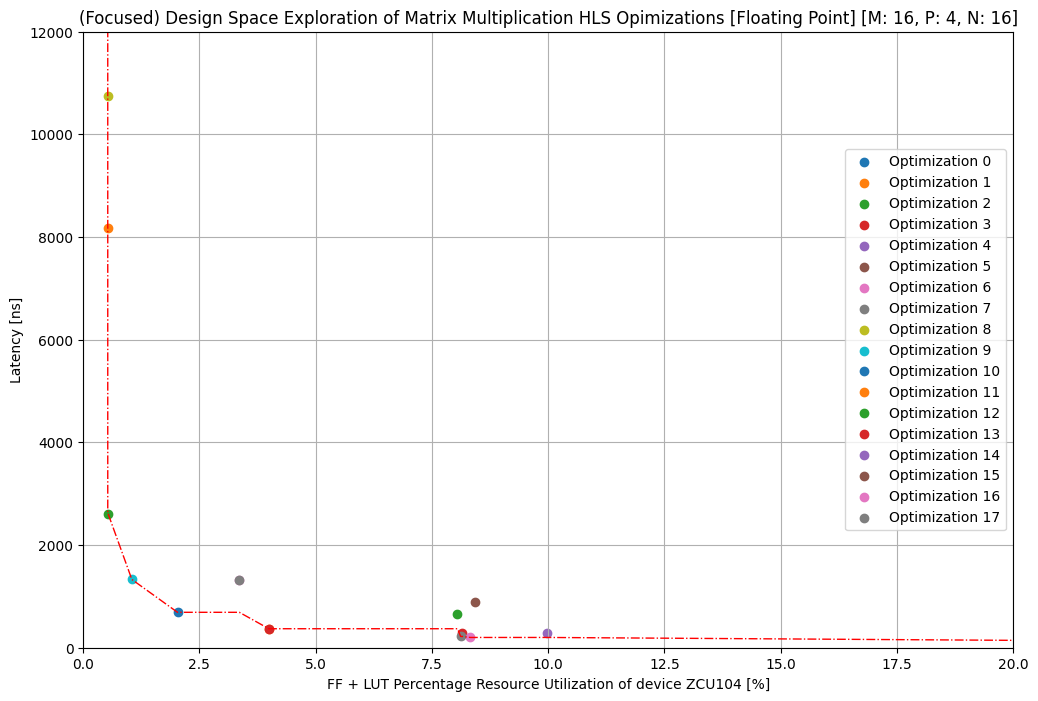

In [95]:
sorted_idx = np.argsort(dfResults["(FF + LUT)%"])
x_sorted = dfResults["(FF + LUT)%"][sorted_idx]
y_sorted = dfResults["Latency_ns"][sorted_idx]

# Find lower envelope points
lower_x = [x_sorted[0]]
lower_y = [y_sorted[0]]

for xi, yi in zip(x_sorted[1:], y_sorted[1:]):
    if yi < lower_y[-1]:
        lower_x.append(xi)
        lower_y.append(yi)
    else:
        # Keep previous lowest as a “step”
        lower_x.append(xi)
        lower_y.append(lower_y[-1])



fig = plt.figure()
fig.set_size_inches(12, 8)

ax = fig.add_subplot(1, 1, 1)

handles: list[any] = []
for i in range(len(dfResults["Latency_ns"])):
    handles.append(ax.scatter(dfResults["(FF + LUT)%"][i], dfResults["Latency_ns"][i], label=dfResults.index[i]))

ax.plot(lower_x, lower_y, color='red', linewidth=1, linestyle="-.", label='Lower Barrier')

ax.legend(handles=handles, loc="center right")
ax.set_xlabel("FF + LUT Percentage Resource Utilization of device ZCU104 [%]")
ax.set_ylabel("Latency [ns]")
ax.set_title("(Focused) Design Space Exploration of Matrix Multiplication HLS Opimizations [Floating Point] [M: 16, P: 4, N: 16]")
ax.set_ylim([0, 12000])
ax.set_xlim([0, 20])

#ax.scatter(dfResults["(FF + LUT)%"], dfResults["Latency_ns"])
ax.grid(True)

In [ ]:
reports.append(HLSReport(
    reportName="Report18",
    latency_ns=49610,
    bram=0,
    dsp=0,
    ff=421992,
    lut=786517,
    uram=0,
    taskSpecificInfo={
        "M": 197,
        "P": 32,
        "N": 197
    },
    optimizations=OptimizationStrategy(
        memory=[
            MemoryOptimization(ArrayPartition(
                "A", dim=2, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=1, type=ArrayPartitionTypes.complete
            )),
            MemoryOptimization(ArrayPartition(
                "C", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
            MemoryOptimization(ArrayPartition(
                "B", dim=2, type=ArrayPartitionTypes.cyclic, factor=4
            )),
        ],
        structure=[
            StructureOptimization(
                label="Function Base", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopM", pipeline=Pipeline(off=True)
            ),
            StructureOptimization(
                label="LoopP", pipeline=Pipeline(off=False), unroll=Unroll(off=False, factor=4)
            ),
            StructureOptimization(
                label="LoopN", pipeline=Pipeline(off=False), unroll=Unroll(off=False)
            )
        ]
    )
))